# Tutorial - Wind Power Prediction Using Gaussian Processes

***Machine Learning for Renewable Energy Systems***

**Timo Lübbing**

**University of Tübingen**

#### Introduction

This tutorial explores the application of Gaussian Processes (GP) in forecasting wind power generation. Through a series of code examples and explanations, you'll gain insights into data preprocessing, feature engineering, and the training and evaluation of GP models for wind energy prediction.

Additionally, we'll examine how different weather input features influence the model's performance.

#### The Data

We have access to the realised energy supply for various energy sources in germany, including on and offshore wind production. In addition, we have access to numerical weather data. Both datasets contain time series data with a 15-minute resolution, covering the perio from 2019 to to 2023. 

#### Preprocessing

Lets get started by loading the data and looking at it.

In [1]:
import sys
import pandas as pd
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LassoCV
from torch.utils.data import DataLoader, TensorDataset

sys.path.append(str(Path("..").resolve()))
from src.visualizations import (
    setup_tueplots,
    plot_wind_power_composition,
    plot_wind_speed_components,
)
from src.preprocessing import (
    Column,
    preprocess_supply_data,
    weather_germany_mean,
    weather_germany_clustered,
    create_time_features,
    create_sliding_window_data,
)
from src.checkpoint import save_checkpoint, load_checkpoint

**Load the Energy Supply Data**

In [4]:
path = Path('..') / 'data' / 'Realised_Supply_Germany.csv'
df = pd.read_csv(path, sep=';', decimal=',')
df.head(2)

,Date from,Date to,Biomass [MW],Hydro Power [MW],Wind Offshore [MW],Wind Onshore [MW],Solar Power [MW],Other Renewable [MW],Nuclear Power [MW],Lignite [MW],Coal [MW],Natural Gas [MW],Pumped Storage [MW],Other Conventional [MW]
0,01.01.19 00:00,01.01.19 00:15,"1.199,00",401.00,"794,25","4.839,25",0,31.5,"2.250,50","1.733,00","836,25","850,5","87,5",431.75
1,01.01.19 00:15,01.01.19 00:30,"1.203,00",394.75,"793,5","5.030,75",0,31.5,"2.263,25","1.587,75","729,5","821,5","99,25",429.75


Proprocessing steps for the energy supply data include:
- Convert to datetime index
- Resample 15-minute intervals to hourly data
- Convert non-numeric columns to float type
- Add a column for the sum of on and offshore wind production. This will be our target variable for the model.

In [5]:
df = preprocess_supply_data(df, resample="h")
df.head(2)

,Biomass [MW],Hydro Power [MW],Wind Offshore [MW],Wind Onshore [MW],Solar Power [MW],Other Renewable [MW],Nuclear Power [MW],Lignite [MW],Coal [MW],Natural Gas [MW],Pumped Storage [MW],Other Conventional [MW],Wind Sum [MW]
Date from,,,,,,,,,,,,,
2019-01-01 00:00:00,4815.25,85420,3134.00,20391.75,0.0,1260,9001.50,6335.0,2811.75,3273.25,271.75,133590,23525.75
2019-01-01 01:00:00,4808.75,50480,2868.25,22365.50,0.0,1260,8535.25,5379.5,2404.25,2967.25,21.50,130290,25233.75


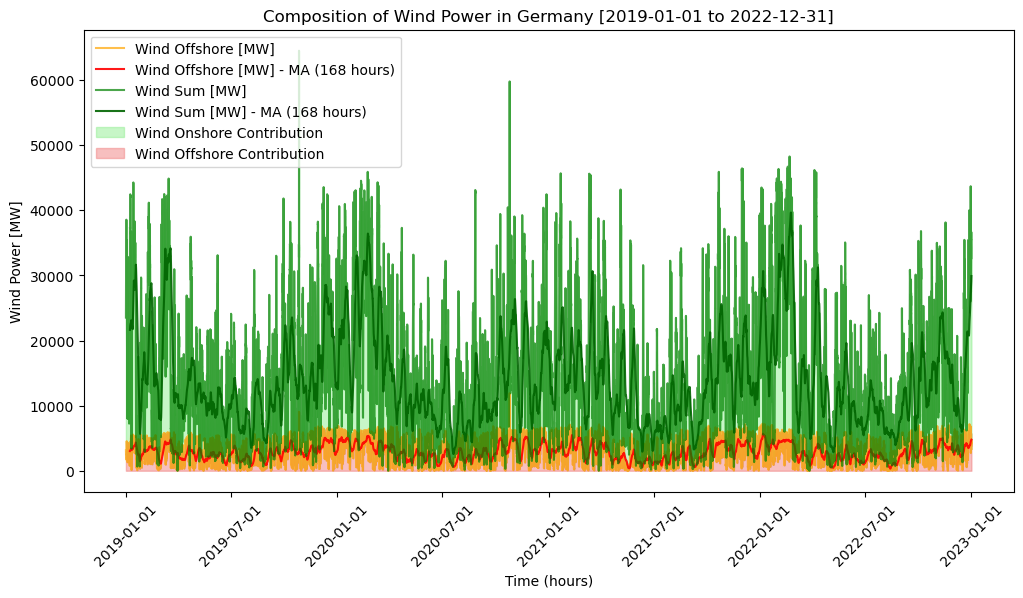

In [4]:
fig = plot_wind_power_composition(
    dates=df.index,
    wind_offshore=df[Column.WIND_OFFSHORE.value],
    wind_onshore=df[Column.WIND_ONSHORE.value],
    moving_average_window=24*7
)

**Wind Power Composition**

We can already see a clear seasonal pattern in the onshore wind production. The offshore wind production is more stable, but also shows some seasonal patterns. Overall, the total wind power production underlies strong noise.

The following code visulalizes the composition of just a single year:

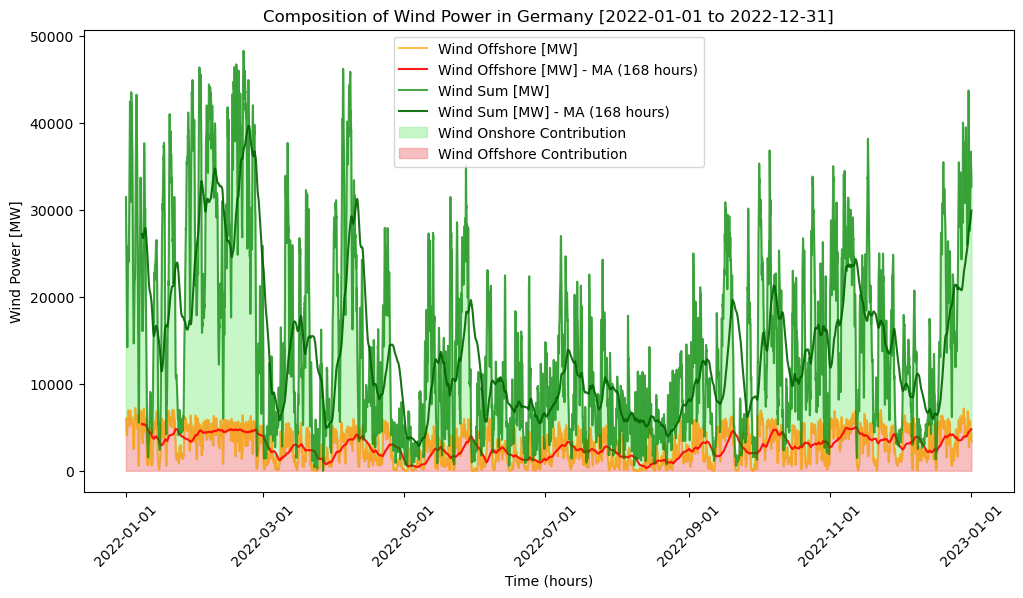

In [5]:
# df_indexed = df["2022-01-01":"2022-12-31"]
df_indexed = df["2022-01-01":"2022-12-31"]
wind_offshore_2022 = df_indexed[Column.WIND_OFFSHORE.value]
wind_onshore_2022 = df_indexed[Column.WIND_ONSHORE.value]
dates_2022 = df_indexed.index

fig = plot_wind_power_composition(
    dates_2022, wind_offshore_2022, wind_onshore_2022, 24*7,
)

**Target Sum of On and Offshore Wind Production**

The below plot shows the total wind power production in Germany for the year 2022. This time series is our target and the year we want to predict within the test set.

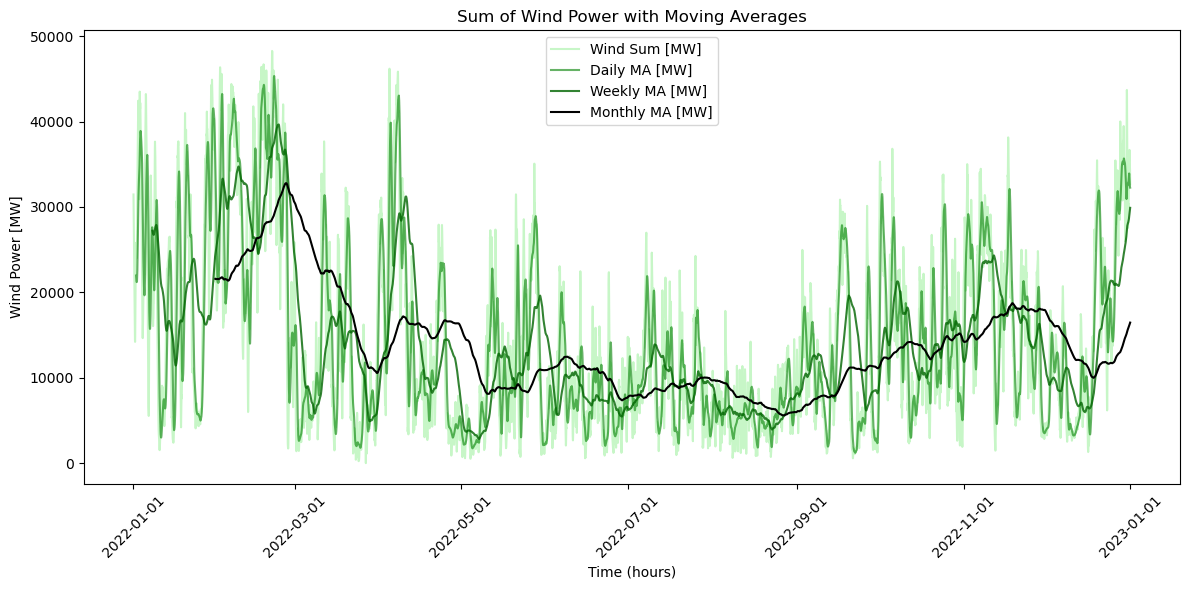

In [6]:
wind = df_indexed[Column.WIND.value]
dates = df_indexed.index

# Calculate moving averages
wind_daily_ma = wind.rolling(window=24).mean()
wind_weekly_ma = wind.rolling(window=24*7).mean()
wind_monthly_ma = wind.rolling(window=24*30).mean()

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
locator = ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator=locator))

ax.plot(dates, wind, label="Wind Sum [MW]", color="lightgreen", alpha=0.5)
ax.plot(dates, wind_daily_ma, label="Daily MA [MW]", color="green", alpha=0.6)
ax.plot(dates, wind_weekly_ma, label="Weekly MA [MW]", color="darkgreen", alpha=0.8)
ax.plot(dates, wind_monthly_ma, label="Monthly MA [MW]", color="black", alpha=1)

ax.set_title("Sum of Wind Power with Moving Averages")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Wind Power [MW]")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Load the Weather Data**

In [6]:
weather_path = Path('..') / "data" / "Weather_Data_Germany.csv"
weather_2022_path = Path('..') / "data" / "Weather_Data_Germany_2022.csv"
weather = pd.read_csv(weather_path, sep=',', decimal='.')
weather_2022 = pd.read_csv(weather_2022_path, sep=',', decimal='.')

weather.head(2)

,longitude,latitude,forecast_origin,time,cdir,z,msl,blh,tcc,u10,v10,t2m,ssr,tsr,sund,tp,fsr,u100,v100
0,5.8,54.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-2.766602,102439.914,766.03015,0.304399,11.806978,2.823900,282.04110,0.0,0.0,0.0,0.0,0.000860,15.666069,3.153420
1,5.8,53.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-6.159180,102795.230,842.93190,0.945699,6.628730,1.767059,281.28223,0.0,0.0,0.0,0.0,0.254992,10.824787,2.401394


Preprocessing steps for the weather data include:
- Convert to datetime index
- Weather data is already in hourly resolution, so no resampling is needed
- Concatenate the disjoint yearly dataframes
- Average the weather data in germany over all weather stations recorded in the dataset.

In [7]:
def format_weather_time(weather: pd.DataFrame) -> None:
    """Formats weather data time column and sets it as index."""
    weather.drop(columns=["forecast_origin"], inplace=True)
    weather["time"] = pd.to_datetime(weather["time"], format="%Y-%m-%d %H:%M:%S")
    weather.set_index("time", inplace=True)
    weather.sort_index(inplace=True)

format_weather_time(weather)
format_weather_time(weather_2022)

weather = pd.concat([weather, weather_2022], axis=0)

In [8]:
# Select preprocessing method:
# 1. mean weather data across Germany
# 2. cluesterd mean weather data (keep parts of location information)

k_clusters = 5
use_clustering = False  # Default: False to reduce complexity

if use_clustering:
    weather = weather_germany_clustered(weather, k_clusters=k_clusters)
else:
    weather = weather_germany_mean(weather)

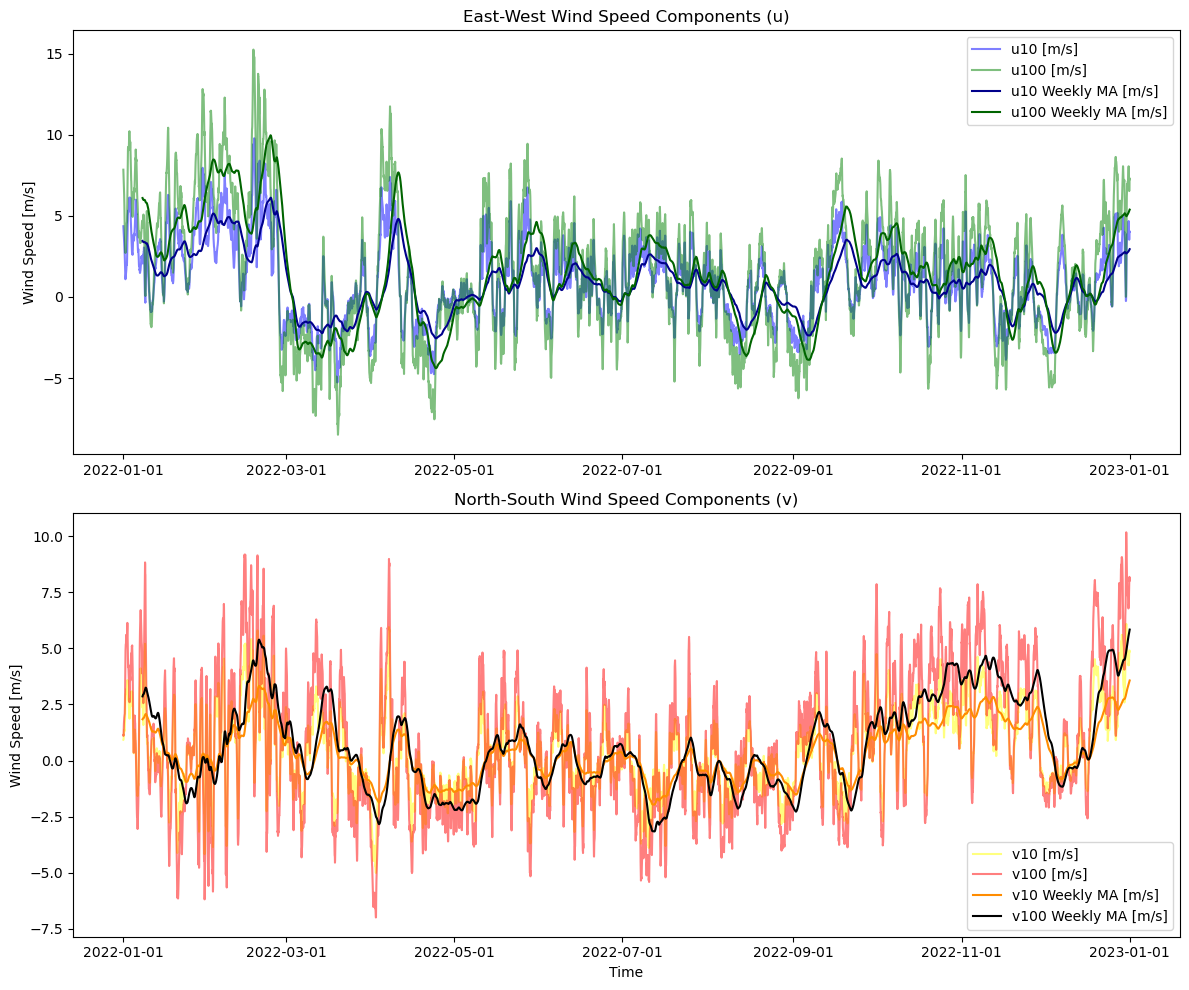

In [10]:
weather_indexed = weather["2022-01-01":"2022-12-31"]
plot_wind_speed_components(weather_indexed)

### **Machine Learning Setup for Forecasting**

At this point in the tutorial we already loaded the given data, looked at the data and provided some basic preprocessing steps. Now, the time series data is aligned and ready for further processing and modeling in the machine learning setup. For time series forecasting, we will need to continue with the following steps to prepare the data for successful and efficient modeling and forecasting:

1. **Split data into training and testing sets**
   
   Carefully split the data in the time series context: Keep the temporal order intact and ensure that the training set prcedes the test set. This is crucial for time series forecasting to avoid data leakage and ensure that the model learns from past data to predict future values. 

2. **Feature engineering**
   
   - Create `time-based features` such as month of the year.
   - Use current weather data as `additional features`
   - Create `lagged features` to capture temporal dependencies in the data. (See sliding window approach below)
   - `Feature scaling`: Normalize or standardize the features to ensure that they are on a similar scale, which is particularly important for Gaussian Processes.
  
3. **Sliding window approach for time series forecasting**
   
   Implement a sliding window approach to create training samples. This involves defining a `window size` that determines how many past observations will be used to predict the next value. The window slides over the time series, creating training samples that consist of the past observations (lagged features), any additional features, and the target variable (the value to be predicted). We can further define the `forecast horizon` (hours) to predict ahead, which will determine how many future values we want to forecast based on the past observations. 
   
4. **Feature selection**
   After feature engineering, it's important to select relevant features that contribute significantly to the model's performance. This reduces complexity and significantly improves computational efficiency. The following methods can be used for feature selection:
   - Select relevant features based on correlation with target variable
   - Mutual Information, Pearson Correlation, Autocorrelation
   - Fit a Lasso regression model and select features based on coefficients (try LassoCV)

In [11]:
# Join weather data with wind data
target = df[[Column.WIND.value]].copy()
dataframe = target.join(weather, how="inner")

# Create time features
dataframe = create_time_features(dataframe)

In [12]:
# Train and test split
SPLIT_DATE = "2022-01-01"
START_DATE = df.index[0]
END_DATE = df.index[-1]

train_data = dataframe[START_DATE:SPLIT_DATE]
test_data = dataframe[SPLIT_DATE:END_DATE]

In [13]:
# Scale target variable
target_scaler = StandardScaler()
train_data.loc[:, [Column.WIND.value]] = target_scaler.fit_transform(
    train_data.loc[:, [Column.WIND.value]]
)
test_data.loc[:, [Column.WIND.value]] = target_scaler.transform(
    test_data.loc[:, [Column.WIND.value]]
)

In [14]:
# Sliding window training
HISTORY_LENGTH = 24  # 24 hours (lag features)
FORECAST_HORIZON = 24  # 24 hours

X_df, y_df = create_sliding_window_data(
    data=train_data,
    history=HISTORY_LENGTH,
    forecast_horizon=FORECAST_HORIZON,
)
X_test_df, y_test_df = create_sliding_window_data(
    data=test_data,
    history=HISTORY_LENGTH,
    forecast_horizon=FORECAST_HORIZON,
)
print(X_df.columns)

Index(['lag_24', 'lag_23', 'lag_22', 'lag_21', 'lag_20', 'lag_19', 'lag_18',
       'lag_17', 'lag_16', 'lag_15', 'lag_14', 'lag_13', 'lag_12', 'lag_11',
       'lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6', 'lag_5', 'lag_4', 'lag_3',
       'lag_2', 'lag_1', 'cdir', 'z', 'msl', 'blh', 'tcc', 'u10', 'v10', 't2m',
       'ssr', 'tsr', 'sund', 'tp', 'fsr', 'u100', 'v100', 'hour_sin',
       'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos',
       'dayofyear_sin', 'dayofyear_cos'],
      dtype='object')


In [15]:
lag_feature_names = [col for col in X_df.columns if col.startswith("lag_")]
time_feature_names = [col for col in X_df.columns if col.endswith("_sin") or col.endswith("_cos")]
weather_feature_names = list(set(X_df.columns) - set(lag_feature_names) - set(time_feature_names))

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ("weather", StandardScaler(), weather_feature_names),
        ("time", "passthrough", time_feature_names),
        ("lag", "passthrough", lag_feature_names),
    ],
    remainder="drop",
)

In [17]:
X_np = preprocessor.fit_transform(X_df)
X_test_np = preprocessor.transform(X_test_df)
X_df = pd.DataFrame(X_np, columns=X_df.columns)
X_test_df = pd.DataFrame(X_test_np, columns=X_test_df.columns)

**Feature Selection**:

In [18]:
# Feature selection methods
selected_lag_features = ["lag_1", "lag_2", "lag_3", "lag_4", "lag_6", "lag_8", "lag_10", "lag_12", "lag_18", "lag_24"]
selected_time_features = ["dayofyear_cos", "month_sin"]
selected_weather_features = ["u100", "v100", "t2m", "ssr"]

selected_features = selected_lag_features + selected_time_features + selected_weather_features
X_df = X_df[selected_features]
X_test_df = X_test_df[selected_features]

### **Gaussian Process Forecasting**
- Exact Gaussian Processes are not tractable for large datasets
- Use Approximate Gaussian Processes (GP) for regression
  - Use the Gpytorch library
  - Variational inference for scalability with ELBO loss training

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
# Transform data to torch tensors
float_precision = torch.float32

X = torch.tensor(X_df.values, dtype=float_precision, device=device)
y = torch.tensor(y_df.values, dtype=float_precision, device=device)
X_test = torch.tensor(X_test_df.values, dtype=float_precision, device=device)
y_test = torch.tensor(y_test_df.values, dtype=float_precision, device=device)
X.shape, y.shape, X_test.shape, y_test.shape

(torch.Size([26281, 16]),
 torch.Size([26281, 24]),
 torch.Size([8713, 16]),
 torch.Size([8713, 24]))

In [21]:
class SparseGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # Variational Distribution & Strategy
        variational_dist = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_dist, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() + 
            gpytorch.kernels.PeriodicKernel() +
            gpytorch.kernels.LinearKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [ ]:
# ---------------------------------------
# 2. Define Sparse GP Model for Multi-step Forecasting
# ---------------------------------------

M_INDUCING_POINTS = 500
LOAD_PRETRAINED = True
CHECKPOINT_NAME = "checkpoint_v1"

total_epochs = 0

models = []
likelihoods = []
mlls = []
optimizers = []

inducing_points_candidates = X[
    torch.randperm(X.size(0))[: max(M_INDUCING_POINTS, X.size(0))]
]  # Ensure we don't exceed X size

for h in range(FORECAST_HORIZON):
    # Select M inducing points from the candidates with resampling
    current_inducing_points = inducing_points_candidates[
        torch.randperm(inducing_points_candidates.size(0))[:M_INDUCING_POINTS]
    ]

    model_h = SparseGPModel(current_inducing_points).to(device)
    likelihood_h = gpytorch.likelihoods.GaussianLikelihood().to(device)
    mll_h = gpytorch.mlls.VariationalELBO(
        likelihood_h, model_h, num_data=X.size(0)
    ).to(device)

    optimizer_h = torch.optim.Adam(
        [
            {"params": model_h.parameters()},
            {"params": likelihood_h.parameters()},
        ],
        lr=0.01,
    )
    
    if LOAD_PRETRAINED:
        total_epochs = load_checkpoint(model_h, likelihood_h, optimizer_h, h, CHECKPOINT_NAME)
        print(f"Loaded checkpoint for horizon {h} at epoch {total_epochs}.")

    models.append(model_h)
    likelihoods.append(likelihood_h)
    mlls.append(mll_h)
    optimizers.append(optimizer_h)

print(f"\nInitialized {len(models)} models.")



Initialized 24 models.


In [28]:
# ---------------------------------------
# 3. Train the Sparse GP models (one for each forecast horizon step)
# ---------------------------------------
CONTINUE_TRAINING = True
NUM_EPOCHS = 100
BATCH_SIZE = 512*16

if CONTINUE_TRAINING:
    for h in range(FORECAST_HORIZON):
        print(f"\nTraining model for forecast step {h+1}/{FORECAST_HORIZON}...")
        model = models[h]
        likelihood = likelihoods[h]
        mll = mlls[h]
        optimizer = optimizers[h]

        # Get the target for the current forecast step
        current_train_y = y[:, h]
        train_dataset = TensorDataset(X, current_train_y)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        model.train()
        likelihood.train()

        for _ in tqdm(range(NUM_EPOCHS)):
            total_epochs += 1
            epoch_loss = 0.0
            
            for X_batch, y_batch in train_loader:
            
                optimizer.zero_grad()
                output = model(X_batch)
                loss = -mll(output, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                
            epoch_loss /= len(train_loader)
            if (total_epochs) % 200 == 0 or total_epochs == 0:
                print(f" Epoch {total_epochs}/{NUM_EPOCHS+total_epochs} -"
                      f" ELBO Loss: {epoch_loss:.3f}")

        # Save the model checkpoint
        save_checkpoint(total_epochs, h, model, likelihood, optimizer, CHECKPOINT_NAME)



Training model for forecast step 1/24...


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_0.pt

Training model for forecast step 2/24...


 67%|██████▋   | 67/100 [00:49<00:24,  1.36it/s]

 Epoch 2600/2700 - ELBO Loss: 0.098


100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_1.pt

Training model for forecast step 3/24...


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_2.pt

Training model for forecast step 4/24...


 67%|██████▋   | 67/100 [00:49<00:25,  1.32it/s]

 Epoch 2800/2900 - ELBO Loss: 0.481


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_3.pt

Training model for forecast step 5/24...


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_4.pt

Training model for forecast step 6/24...


 67%|██████▋   | 67/100 [00:49<00:25,  1.31it/s]

 Epoch 3000/3100 - ELBO Loss: 0.673


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_5.pt

Training model for forecast step 7/24...


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_6.pt

Training model for forecast step 8/24...


 67%|██████▋   | 67/100 [00:49<00:25,  1.32it/s]

 Epoch 3200/3300 - ELBO Loss: 0.819


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_7.pt

Training model for forecast step 9/24...


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_8.pt

Training model for forecast step 10/24...


 67%|██████▋   | 67/100 [00:49<00:23,  1.38it/s]

 Epoch 3400/3500 - ELBO Loss: 0.934


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_9.pt

Training model for forecast step 11/24...


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_10.pt

Training model for forecast step 12/24...


 67%|██████▋   | 67/100 [00:49<00:23,  1.38it/s]

 Epoch 3600/3700 - ELBO Loss: 1.018


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_11.pt

Training model for forecast step 13/24...


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_12.pt

Training model for forecast step 14/24...


 67%|██████▋   | 67/100 [00:49<00:24,  1.32it/s]

 Epoch 3800/3900 - ELBO Loss: 1.034


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_13.pt

Training model for forecast step 15/24...


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_14.pt

Training model for forecast step 16/24...


 67%|██████▋   | 67/100 [00:49<00:24,  1.35it/s]

 Epoch 4000/4100 - ELBO Loss: 1.147


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_15.pt

Training model for forecast step 17/24...


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_16.pt

Training model for forecast step 18/24...


 67%|██████▋   | 67/100 [00:49<00:23,  1.38it/s]

 Epoch 4200/4300 - ELBO Loss: 1.177


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_17.pt

Training model for forecast step 19/24...


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_18.pt

Training model for forecast step 20/24...


 67%|██████▋   | 67/100 [00:50<00:24,  1.35it/s]

 Epoch 4400/4500 - ELBO Loss: 1.206


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_19.pt

Training model for forecast step 21/24...


100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_20.pt

Training model for forecast step 22/24...


 67%|██████▋   | 67/100 [00:49<00:24,  1.36it/s]

 Epoch 4600/4700 - ELBO Loss: 1.230


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_21.pt

Training model for forecast step 23/24...


100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_22.pt

Training model for forecast step 24/24...


 67%|██████▋   | 67/100 [00:49<00:23,  1.41it/s]

 Epoch 4800/4900 - ELBO Loss: 1.247


100%|██████████| 100/100 [01:13<00:00,  1.35it/s]

Checkpoint saved to ../checkpoints/checkpoint_v1/horizon_23.pt



Predicted means shape: (8713, 24)
True test Y shape: (8713, 24)
Average Test RMSE across horizon: 5778.588


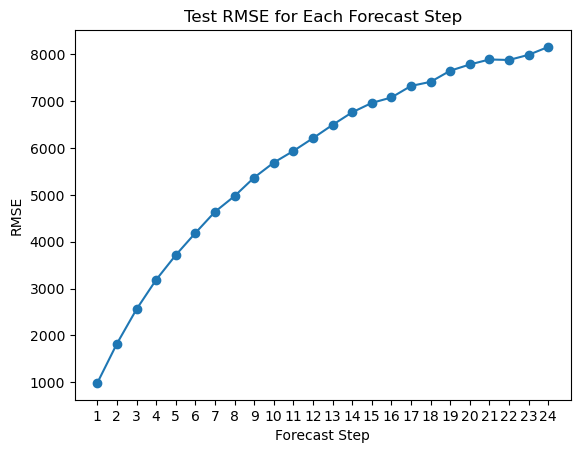

In [30]:
# ---------------------------------------
# 4. Evaluate on Test Data
# ---------------------------------------
all_means_test = []
all_vars_test = []

for h in range(FORECAST_HORIZON):
    # print(f"Evaluating model for forecast step {h+1}/{FORECAST_HORIZON}...")
    model = models[h]
    likelihood = likelihoods[h]

    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # test_x are the lagged features from the test set
        preds_h = likelihood(model(X_test))
        mean_h = preds_h.mean.cpu().numpy()
        var_h = preds_h.variance.cpu().numpy()

    all_means_test.append(mean_h)
    all_vars_test.append(var_h)

# Stack predictions: results in shape (num_test_samples, FORECAST_HORIZON)
predicted_means_test = np.stack(all_means_test, axis=1)
predicted_vars_test = np.stack(all_vars_test, axis=1)

predicted_means_test = target_scaler.inverse_transform(predicted_means_test)
predicted_vars_test = target_scaler.inverse_transform(predicted_vars_test)
# y_test = target_scaler.inverse_transform(y_test.cpu().numpy())
print(f"\nPredicted means shape: {predicted_means_test.shape}")  # Shape (# samples, H)
print(f"True test Y shape: {y_test.shape}")

# Compute RMSE for each forecast step
rmses_per_step = []
for h in range(FORECAST_HORIZON):
    true_h = y_test[:, h]
    pred_h = predicted_means_test[:, h]
    rmse_h = root_mean_squared_error(true_h, pred_h)
    rmses_per_step.append(rmse_h)
    # print(f"Test RMSE for step {h+1}: {rmse_h:.3f}")

print(f"Average Test RMSE across horizon: {np.mean(rmses_per_step):.3f}")

plt.plot(np.arange(1, FORECAST_HORIZON + 1), rmses_per_step, marker="o", label="RMSE")
plt.xticks(np.arange(1, FORECAST_HORIZON + 1))
plt.xlabel("Forecast Step")
plt.ylabel("RMSE")
plt.title("Test RMSE for Each Forecast Step")
plt.show()


In [31]:
N_BEST_SAMPLES = 1

sample_rmse_with_idx = []
for idx in range(len(y_test)):
    true = y_test[idx]
    pred = predicted_means_test[idx]
    rmse = root_mean_squared_error(true, pred)
    sample_rmse_with_idx.append((idx, rmse))
    
# Calculate the average RMSE from the rmse values
rmse_values = [x[1] for x in sample_rmse_with_idx]
print(f"Average RMSE for all samples: {np.mean(rmse_values):.3f}")

# Sort by RMSE value
sample_rmse_with_idx.sort(key=lambda x: x[1])
best_indices = [x[0] for x in sample_rmse_with_idx[:N_BEST_SAMPLES]]
worst_indices = [x[0] for x in sample_rmse_with_idx[-N_BEST_SAMPLES:]]
print(f"Best indices: {best_indices}")
print(f"Worst indices: {worst_indices}")
indices = best_indices + worst_indices

Average RMSE for all samples: 5273.557
Best indices: [8365]
Worst indices: [0]


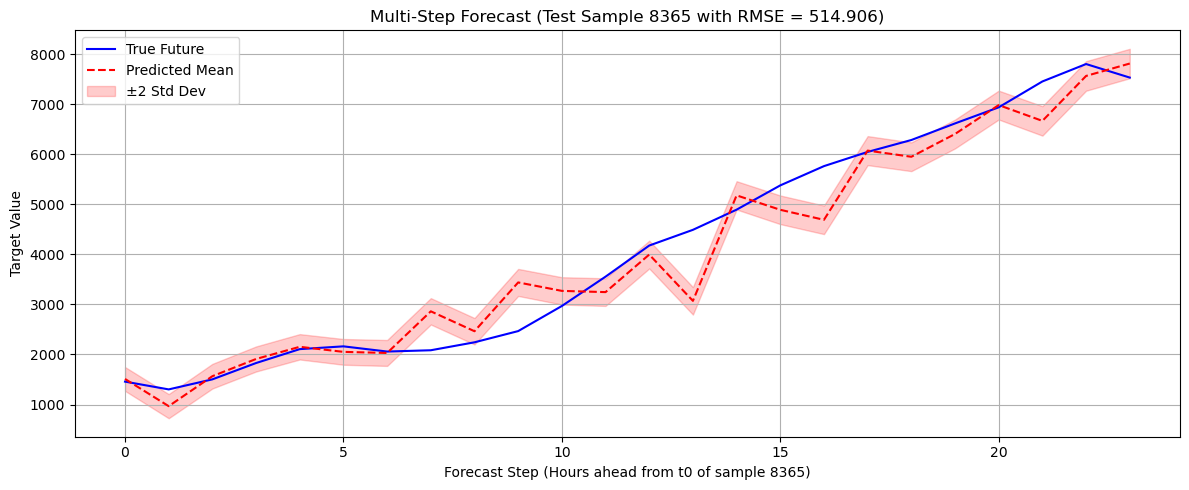

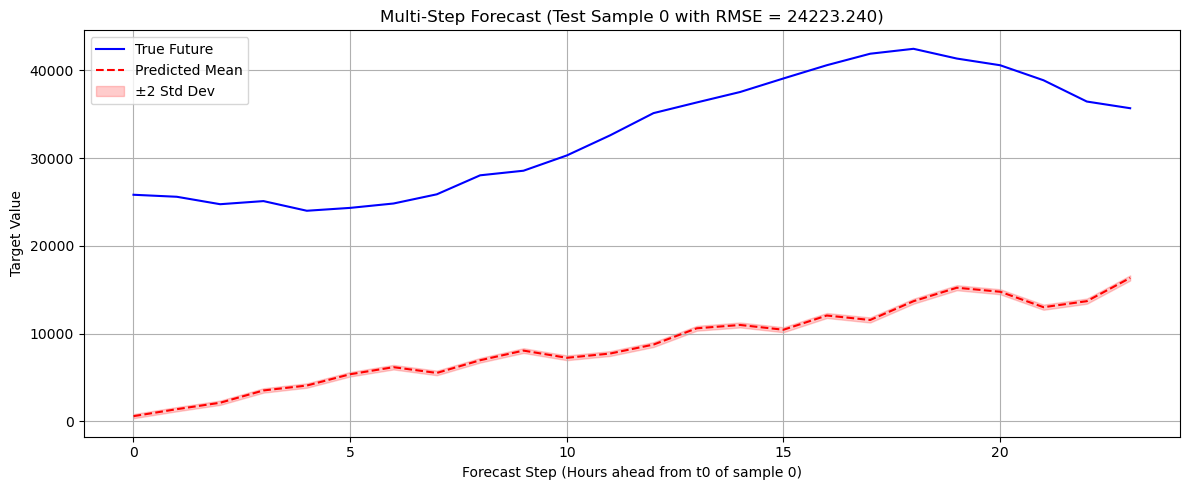

In [32]:
# ---------------------------------------
# 5. Plot Results for a few forecast sequences
# ------------------------

for i in indices:
    plt.figure(figsize=(12, 5))

    # Define the x-axis for the forecast horizon
    forecast_steps_axis = np.arange(FORECAST_HORIZON)

    # True future values for this sequence
    true_future_sequence = y_test[i, :]

    # Predicted future values for this sequence
    predicted_future_sequence = predicted_means_test[i, :]
    predicted_future_vars = predicted_vars_test[i, :]

    plt.plot(
        forecast_steps_axis, true_future_sequence, "b-", label="True Future"
    )
    plt.plot(
        forecast_steps_axis, predicted_future_sequence, "r--", label="Predicted Mean"
    )

    upper_bound = predicted_future_sequence + 2 * np.sqrt(predicted_future_vars)
    lower_bound = predicted_future_sequence - 2 * np.sqrt(predicted_future_vars)
    plt.fill_between(
        forecast_steps_axis,
        lower_bound,
        upper_bound,
        color="red",
        alpha=0.2,
        label="±2 Std Dev",
    )

    plt.title(f"Multi-Step Forecast (Test Sample {i} with RMSE = {rmse_values[i]:.3f})")
    plt.xlabel(f"Forecast Step (Hours ahead from t0 of sample {i})")
    plt.ylabel("Target Value")
    # plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


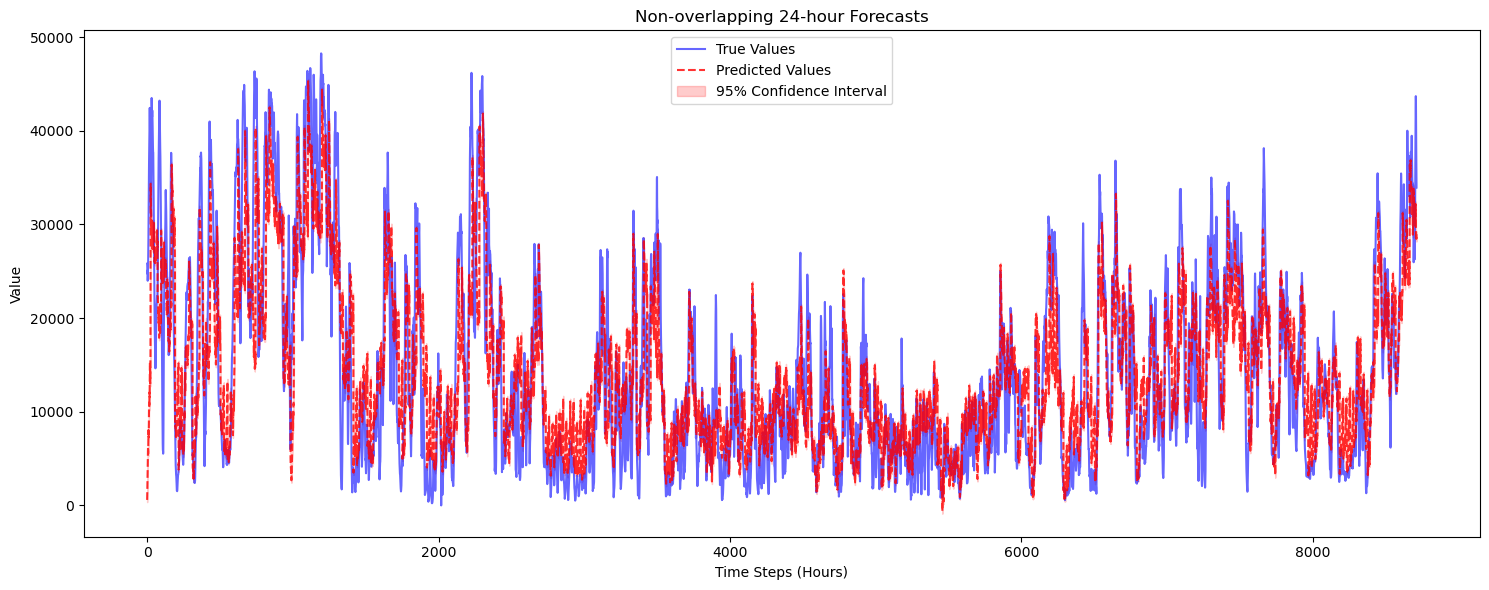

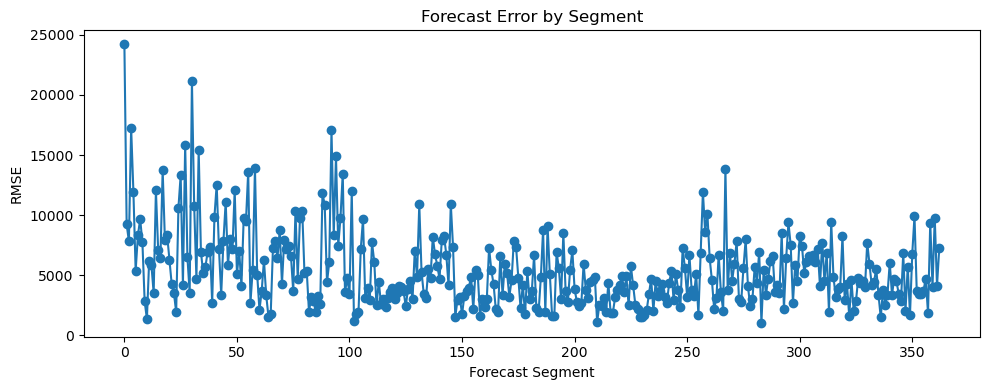

In [33]:
# ---------------------------------------
# 2. Plot along the entire test set
# ---------------------------------------

# Calculate how many non-overlapping 24-hour segments we can have
number_non_overlapping_test_samples = len(y_test) // FORECAST_HORIZON

# Create time axis for the entire plot
time_axis = np.arange(number_non_overlapping_test_samples * FORECAST_HORIZON)

plt.figure(figsize=(15, 6))

# Extract actual values for the same time points we'll be forecasting
true_values = []
predicted_values = []
confidence_lower = []
confidence_upper = []

# For each non-overlapping segment
for i in range(number_non_overlapping_test_samples):
    # Get the index in the test data
    idx = i * FORECAST_HORIZON

    # Extract true values for this segment
    segment_true = y_test[idx]
    true_values.extend(segment_true)

    # Extract predictions for this segment
    segment_predicted = predicted_means_test[idx]
    predicted_values.extend(segment_predicted)

    # Calculate confidence intervals
    segment_vars = predicted_vars_test[idx]
    segment_lower = segment_predicted - 2 * np.sqrt(segment_vars)
    segment_upper = segment_predicted + 2 * np.sqrt(segment_vars)
    confidence_lower.extend(segment_lower)
    confidence_upper.extend(segment_upper)

# Convert to numpy arrays
true_values = np.array(true_values)
predicted_values = np.array(predicted_values)
confidence_lower = np.array(confidence_lower)
confidence_upper = np.array(confidence_upper)

# Plot true values
plt.plot(time_axis, true_values, "b-", label="True Values", alpha=0.6)

# Plot predicted values
plt.plot(time_axis, predicted_values, "r--", label="Predicted Values", alpha=0.8)

# Plot confidence intervals
plt.fill_between(
    time_axis,
    confidence_lower,
    confidence_upper,
    color="red",
    alpha=0.2,
    label="95% Confidence Interval",
)

# Add vertical lines to separate the 24-hour segments
# for i in range(1, number_non_overlapping_test_samples):
#     plt.axvline(x=i * FORECAST_HORIZON, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Time Steps (Hours)")
plt.ylabel("Value")
plt.title("Non-overlapping 24-hour Forecasts")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Display forecast metrics for each segment
segment_rmses = []
for i in range(number_non_overlapping_test_samples):
    idx = i * FORECAST_HORIZON
    segment_true = y_test[idx]
    segment_predicted = predicted_means_test[idx]
    segment_rmse = root_mean_squared_error(segment_true, segment_predicted)
    segment_rmses.append(segment_rmse)

plt.figure(figsize=(10, 4))
plt.plot(np.arange(number_non_overlapping_test_samples), segment_rmses, marker="o")
plt.xlabel("Forecast Segment")
plt.ylabel("RMSE")
plt.title("Forecast Error by Segment")
plt.tight_layout()
plt.show()


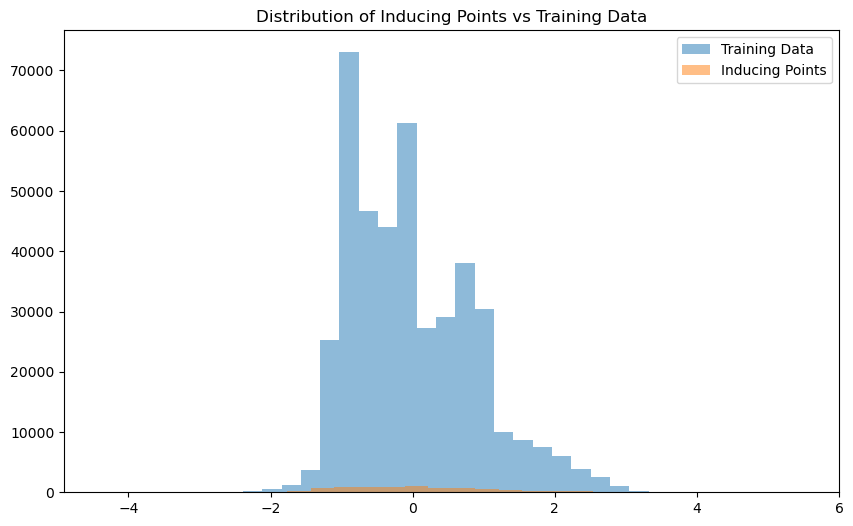

In [35]:
def visualize_inducing_points(model, X_train):
    # Plot the distribution of inducing points vs. training data
    plt.figure(figsize=(10, 6))
    plt.hist(X_train.cpu().numpy().flatten(), bins=30, alpha=0.5, label="Training Data")
    plt.hist(
        model.variational_strategy.inducing_points.cpu().detach().numpy().flatten(),
        bins=30,
        alpha=0.5,
        label="Inducing Points",
    )
    plt.legend()
    plt.title("Distribution of Inducing Points vs Training Data")
    plt.show()

visualize_inducing_points(models[0], X)